In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import glob, os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from bokeh.plotting import figure, show
from bokeh.palettes import Spectral4
# from bkcharts import TimeSeries, output_file, show
from bokeh.io import output_notebook
output_notebook()

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

Using TensorFlow backend.


Loading BokehJS ...

# Data Preparation

Data yang digunakan untuk pengujian ini dataset delay penerbangan kota New York pada bulan Januari 2019. Data ini awalnya terdapat 16 atribut. **CRS** berarti waktu yang sudah terjadwal, sedangkan **ACTUAL** berarti waktu yang sebenarnya terjadi. *Departure delay* berupa anga dalam satuan menit, bila data > 0 maka terjadi *delay*, bila data = 0 berarti keberangkatan tepat waktu, sedangkan data < 0 (atau negatif) berarti keberangkatan lebih awal.

In [2]:
data = pd.concat(map(pd.read_csv, glob.glob(os.path.join('dataset/2years', '*.csv'))))

In [3]:
data.reset_index(inplace=True, drop=True)
data = data.drop(['Unnamed: 18'], axis=1)
data.shape

(1450183, 18)

In [4]:
# data.to_csv('2years.csv')

### Convert FL_DATE to datetime

In [5]:
data['FL_DATE'] = pd.to_datetime(data.FL_DATE)
# data['CRS_DEP_TIME'] = pd.to_datetime(data['CRS_DEP_TIME'], format='%H%M').dt.time
# data['FL_DATE'] +=  pd.to_timedelta(data.CRS_DEP_TIME.astype(str), unit='s')

### Split *CRS departure time* during 00:00 - 00:59

In [6]:
dropindex = []
for i in data.itertuples():
    x = len(str(i.CRS_DEP_TIME))
    if x == 1 or x == 2:
        dropindex.append(i.Index)
data1 = data.loc[dropindex]
data.drop(data.index[dropindex], inplace=True)
data1.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
489,2018-01-01,12892,"Los Angeles, CA",12478,"New York, NY",40,55.0,15.0,856,846.0,-10.0,0.0,0.0,316.0,291.0,271.0,1.0,2475.0
2149,2018-01-02,12892,"Los Angeles, CA",12478,"New York, NY",40,37.0,-3.0,856,905.0,9.0,0.0,0.0,316.0,328.0,296.0,1.0,2475.0
2742,2018-01-02,11057,"Charlotte, NC",14576,"Rochester, NY",10,10.0,0.0,153,147.0,-6.0,0.0,0.0,103.0,97.0,77.0,1.0,573.0
2964,2018-01-02,11298,"Dallas/Fort Worth, TX",12478,"New York, NY",5,5.0,0.0,429,402.0,-27.0,0.0,0.0,204.0,177.0,160.0,1.0,1391.0
3497,2018-01-02,11292,"Denver, CO",12953,"New York, NY",53,119.0,26.0,637,646.0,9.0,0.0,0.0,224.0,207.0,191.0,1.0,1620.0


In [7]:
data.loc[data['CRS_DEP_TIME'] == 9]

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE


## Convert *CRS departure time* from int to time

In [8]:
data['CRS_DEP_TIME'] = pd.to_datetime(data['CRS_DEP_TIME'], format='%H%M').dt.time
data1['CRS_DEP_TIME'] = pd.to_datetime(data1['CRS_DEP_TIME'], format='%M').dt.time
# data2['CRS_DEP_TIME'] = pd.to_datetime(data2['CRS_DEP_TIME'], format='%M').dt.time

### Merge *CRS departure time*

In [9]:
data = data.append(data1)
data.sort_index(inplace=True)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
0,2018-01-01,13930,"Chicago, IL",10257,"Albany, NY",06:30:00,650.0,20.0,922,936.0,14.0,0.0,0.0,112.0,106.0,83.0,1.0,723.0
1,2018-01-01,10257,"Albany, NY",13930,"Chicago, IL",10:04:00,1022.0,18.0,1134,1124.0,-10.0,0.0,0.0,150.0,122.0,106.0,1.0,723.0
2,2018-01-01,10257,"Albany, NY",13930,"Chicago, IL",06:15:00,748.0,93.0,746,850.0,64.0,0.0,0.0,151.0,122.0,108.0,1.0,723.0
3,2018-01-01,12953,"New York, NY",12266,"Houston, TX",07:52:00,741.0,-11.0,1101,1052.0,-9.0,0.0,0.0,249.0,251.0,228.0,1.0,1416.0
4,2018-01-01,12266,"Houston, TX",12953,"New York, NY",16:20:00,1618.0,-2.0,2046,2045.0,-1.0,0.0,0.0,206.0,207.0,180.0,1.0,1416.0


In [10]:
data['FL_DATE'] +=  pd.to_timedelta(data.CRS_DEP_TIME.astype(str), unit='s')
data = data.sort_values(by='FL_DATE',ascending=True)
data.reset_index(inplace=True, drop=True)
data.head()
data.loc[data['DEP_TIME'] == 7]

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
10366,2018-01-06 23:55:00,12892,"Los Angeles, CA",12478,"New York, NY",23:55:00,7.0,12.0,815,902.0,47.0,0.0,0.0,320.0,355.0,284.0,1.0,2475.0
12060,2018-01-07 19:51:00,12478,"New York, NY",11697,"Fort Lauderdale, FL",19:51:00,7.0,256.0,2325,303.0,218.0,0.0,0.0,214.0,176.0,152.0,1.0,1069.0
14400,2018-01-08 23:58:00,10140,"Albuquerque, NM",12478,"New York, NY",23:58:00,7.0,9.0,551,609.0,18.0,0.0,0.0,233.0,242.0,226.0,1.0,1826.0
22746,2018-01-12 21:58:00,11433,"Detroit, MI",10577,"Binghamton, NY",21:58:00,7.0,129.0,2332,131.0,119.0,0.0,0.0,94.0,84.0,66.0,1.0,378.0
24138,2018-01-13 23:59:00,12478,"New York, NY",14843,"San Juan, PR",23:59:00,7.0,8.0,443,451.0,8.0,0.0,0.0,224.0,224.0,200.0,1.0,1598.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361937,2019-10-17 22:46:00,12953,"New York, NY",11292,"Denver, CO",22:46:00,7.0,81.0,101,200.0,59.0,0.0,0.0,255.0,233.0,212.0,1.0,1620.0
1393154,2019-11-02 23:55:00,14771,"San Francisco, CA",12478,"New York, NY",23:55:00,7.0,12.0,735,819.0,44.0,0.0,0.0,280.0,312.0,226.0,1.0,2586.0
1420757,2019-11-15 23:59:00,14869,"Salt Lake City, UT",12478,"New York, NY",23:59:00,7.0,8.0,609,614.0,5.0,0.0,0.0,250.0,247.0,229.0,1.0,1990.0
1426377,2019-11-18 19:59:00,12953,"New York, NY",11193,"Cincinnati, OH",19:59:00,7.0,248.0,2220,155.0,215.0,0.0,0.0,141.0,108.0,90.0,1.0,585.0


In [11]:
data.head(10)
data.shape[0]

1450183

In [12]:
duplicated = data[data.duplicated(subset='FL_DATE', keep='first')]
duplicated.shape[0]

993682

In [13]:
data = data.drop_duplicates(subset='FL_DATE', keep='first')
data.reset_index(inplace=True, drop=True)

In [14]:
data.shape[0]
# data.head(10)

456501

### Check NaN

In [15]:
data.isna().sum()

FL_DATE                    0
ORIGIN_AIRPORT_ID          0
ORIGIN_CITY_NAME           0
DEST_AIRPORT_ID            0
DEST_CITY_NAME             0
CRS_DEP_TIME               0
DEP_TIME               12505
DEP_DELAY              13171
CRS_ARR_TIME               0
ARR_TIME               13395
ARR_DELAY              15049
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           1
ACTUAL_ELAPSED_TIME    14729
AIR_TIME               14729
FLIGHTS                    0
DISTANCE                   0
dtype: int64

### Drop NaN and check again

In [16]:
data = data.dropna(subset=['DEP_DELAY', 'ARR_DELAY'])
data.isna().sum()

FL_DATE                0
ORIGIN_AIRPORT_ID      0
ORIGIN_CITY_NAME       0
DEST_AIRPORT_ID        0
DEST_CITY_NAME         0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
FLIGHTS                0
DISTANCE               0
dtype: int64

### Calculate *Departure time* based on *Departure delay*

Because there is some error with value in DEP_DELAY column, so we need to calculate its value to make sure the value is right.

In [17]:
# Example, the value of departure delay is only 1 digit (7) 
# because int dtype cannot display 0 before integer. 
data.loc[1223]

FL_DATE                2018-01-03 10:35:00
ORIGIN_AIRPORT_ID                    10397
ORIGIN_CITY_NAME               Atlanta, GA
DEST_AIRPORT_ID                      12478
DEST_CITY_NAME                New York, NY
CRS_DEP_TIME                      10:35:00
DEP_TIME                              1039
DEP_DELAY                                4
CRS_ARR_TIME                          1250
ARR_TIME                              1238
ARR_DELAY                              -12
CANCELLED                                0
DIVERTED                                 0
CRS_ELAPSED_TIME                       135
ACTUAL_ELAPSED_TIME                    119
AIR_TIME                                96
FLIGHTS                                  1
DISTANCE                               760
Name: 1223, dtype: object

In [18]:
for row in data.itertuples():
    i = row.CRS_DEP_TIME
    j = row.DEP_DELAY
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    if j<0:
        d = dt.timedelta(minutes=abs(j))
        k = c - d
    else:
        d = dt.timedelta(minutes=j)
        k = c + d
    if row.DEP_TIME != k:
        data.at[row.Index, 'DEP_TIME'] = k

In [19]:
# data.loc[1609]
data.loc[1223]

FL_DATE                2018-01-03 10:35:00
ORIGIN_AIRPORT_ID                    10397
ORIGIN_CITY_NAME               Atlanta, GA
DEST_AIRPORT_ID                      12478
DEST_CITY_NAME                New York, NY
CRS_DEP_TIME                      10:35:00
DEP_TIME                          10:39:00
DEP_DELAY                                4
CRS_ARR_TIME                          1250
ARR_TIME                              1238
ARR_DELAY                              -12
CANCELLED                                0
DIVERTED                                 0
CRS_ELAPSED_TIME                       135
ACTUAL_ELAPSED_TIME                    119
AIR_TIME                                96
FLIGHTS                                  1
DISTANCE                               760
Name: 1223, dtype: object

### Delete day on *Departure time*

In [20]:
to_str = []
for row in data.itertuples():
    i = len(str(row.DEP_TIME))
    if i != 8:
        to_str.append(row.Index)

In [21]:
data3 = data.loc[set(data.index) - set(to_str)]
data4 = data.loc[to_str]

data3['DEP_TIME'] = pd.to_datetime(data3['DEP_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data4['DEP_TIME'] = pd.to_datetime(data4['DEP_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [22]:
# data4.loc[1609]

### Merge

In [23]:
data = data3.append(data4)
data.head(3)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
16,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,900,1428.0,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0
29,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,759,1146.0,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0
44,2018-01-01 07:10:00,12478,"New York, NY",12892,"Los Angeles, CA",07:10:00,10:21:00,191.0,1030,1339.0,189.0,0.0,0.0,380.0,378.0,347.0,1.0,2475.0


### Calculate CRS Arrival time based on CRS Elapsed time

Because there is some error with value in CRS_ARR_TIME column, so we need to calculate its value to make sure the value is right.

In [24]:
for row in data.itertuples():
    i = row.CRS_DEP_TIME
    j = row.CRS_ELAPSED_TIME
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    d = dt.timedelta(minutes=j)
    k = c + d
    if row.CRS_ARR_TIME != k:
        data.at[row.Index, 'CRS_ARR_TIME'] = k

In [25]:
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
16,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,8:00:00,1428.0,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0
29,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,8:59:00,1146.0,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0
44,2018-01-01 07:10:00,12478,"New York, NY",12892,"Los Angeles, CA",07:10:00,10:21:00,191.0,13:30:00,1339.0,189.0,0.0,0.0,380.0,378.0,347.0,1.0,2475.0
77,2018-01-01 08:20:00,13930,"Chicago, IL",15096,"Syracuse, NY",08:20:00,10:44:00,144.0,9:58:00,1317.0,139.0,0.0,0.0,98.0,93.0,83.0,1.0,607.0
84,2018-01-01 08:35:00,13232,"Chicago, IL",12953,"New York, NY",08:35:00,12:14:00,219.0,10:40:00,1536.0,236.0,0.0,0.0,125.0,142.0,91.0,1.0,725.0


In [26]:
to_str = []
for row in data.itertuples():
    i = len(str(row.CRS_ARR_TIME))
    if i != 8:
        to_str.append(row.Index)

In [27]:
data6 = data.loc[set(data.index) - set(to_str)]
data7 = data.loc[to_str]

data6['CRS_ARR_TIME'] = pd.to_datetime(data6['CRS_ARR_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data7['CRS_ARR_TIME'] = pd.to_datetime(data7['CRS_ARR_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [28]:
data = data6.append(data7)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
18,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,953.0,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0
35,2018-01-01 06:42:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:42:00,06:54:00,12.0,12:25:00,1008.0,-17.0,0.0,0.0,343.0,314.0,290.0,1.0,1990.0
38,2018-01-01 06:50:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",06:50:00,07:46:00,56.0,11:06:00,1048.0,42.0,0.0,0.0,256.0,242.0,215.0,1.0,1389.0
43,2018-01-01 07:05:00,12478,"New York, NY",13487,"Minneapolis, MN",07:05:00,07:11:00,6.0,10:36:00,907.0,-29.0,0.0,0.0,211.0,176.0,148.0,1.0,1029.0
44,2018-01-01 07:10:00,12478,"New York, NY",12892,"Los Angeles, CA",07:10:00,10:21:00,191.0,13:30:00,1339.0,189.0,0.0,0.0,380.0,378.0,347.0,1.0,2475.0


### Calculate Arrival time based on Arrival delay

Because there is some error with value in ARR_TIME column, so we need to calculate its value to make sure the value is right.

In [29]:
for row in data.itertuples():
    i = row.CRS_ARR_TIME
    j = row.ARR_DELAY
    c = dt.timedelta(hours=i.hour, minutes=i.minute, seconds=i.second)
    if j<0:
        d = dt.timedelta(minutes=abs(j))
        k = c - d
    else:
        d = dt.timedelta(minutes=j)
        k = c + d
    if row.ARR_TIME != k:
        data.at[row.Index, 'ARR_TIME'] = k

In [30]:
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
18,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0
35,2018-01-01 06:42:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:42:00,06:54:00,12.0,12:25:00,12:08:00,-17.0,0.0,0.0,343.0,314.0,290.0,1.0,1990.0
38,2018-01-01 06:50:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",06:50:00,07:46:00,56.0,11:06:00,11:48:00,42.0,0.0,0.0,256.0,242.0,215.0,1.0,1389.0
43,2018-01-01 07:05:00,12478,"New York, NY",13487,"Minneapolis, MN",07:05:00,07:11:00,6.0,10:36:00,10:07:00,-29.0,0.0,0.0,211.0,176.0,148.0,1.0,1029.0
44,2018-01-01 07:10:00,12478,"New York, NY",12892,"Los Angeles, CA",07:10:00,10:21:00,191.0,13:30:00,16:39:00,189.0,0.0,0.0,380.0,378.0,347.0,1.0,2475.0


In [31]:
to_str = []
for row in data.itertuples():
    i = len(str(row.ARR_TIME))
    if i != 8:
        to_str.append(row.Index)

In [32]:
data8 = data.loc[set(data.index) - set(to_str)]
data9 = data.loc[to_str]

data8['ARR_TIME'] = pd.to_datetime(data8['ARR_TIME'].astype(str).str[-8:], format='%H:%M:%S').dt.time
data9['ARR_TIME'] = pd.to_datetime(data9['ARR_TIME'].astype(str).str[-7:], format='%H:%M:%S').dt.time

In [33]:
data = data8.append(data9)
data.reset_index(inplace=True, drop=True)
data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0
3,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,08:59:00,12:46:00,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0
4,2018-01-01 06:24:00,12478,"New York, NY",13495,"New Orleans, LA",06:24:00,06:18:00,-6.0,09:46:00,10:11:00,25.0,0.0,0.0,202.0,233.0,193.0,1.0,1182.0


### Working Day or not

In [34]:
data["DAY_TYPE"] = data.FL_DATE.apply(lambda x: 1 if x.dayofweek > 5 else 0)
data.head(3)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0,0
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0,0
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0,0


### Finding Federal Holidays

In [35]:
cal = calendar()
holidays = cal.holidays(start = data.FL_DATE.min(), end = data.FL_DATE.max())
data["IS_HOLIDAY"] = data.FL_DATE.isin(holidays)
data

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0,0,False
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0,0,False
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0,0,False
3,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,08:59:00,12:46:00,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0,0,False
4,2018-01-01 06:24:00,12478,"New York, NY",13495,"New Orleans, LA",06:24:00,06:18:00,-6.0,09:46:00,10:11:00,25.0,0.0,0.0,202.0,233.0,193.0,1.0,1182.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440817,2019-11-30 23:46:00,14107,"Phoenix, AZ",12478,"New York, NY",23:46:00,00:28:00,42.0,04:16:00,04:29:00,13.0,0.0,0.0,270.0,241.0,223.0,1.0,2153.0,0,False
440818,2019-11-30 23:49:00,14869,"Salt Lake City, UT",12478,"New York, NY",23:49:00,00:09:00,20.0,03:59:00,04:24:00,25.0,0.0,0.0,250.0,255.0,234.0,1.0,1990.0,0,False
440819,2019-11-30 23:52:00,13796,"Oakland, CA",12478,"New York, NY",23:52:00,00:02:00,10.0,05:11:00,05:22:00,11.0,0.0,0.0,319.0,320.0,285.0,1.0,2576.0,0,False
440820,2019-11-30 23:55:00,12892,"Los Angeles, CA",12478,"New York, NY",23:55:00,00:15:00,20.0,05:17:00,05:31:00,14.0,0.0,0.0,322.0,316.0,267.0,1.0,2475.0,0,False


### Departure from NY or Arrival to NY

In [36]:
data['DEP_FROM_NY'] = data.ORIGIN_CITY_NAME.apply(lambda x: 1 if x[-2:] == 'NY' else 0)
data.head(10)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0,0,False,0
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0,0,False,0
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0,0,False,1
3,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,08:59:00,12:46:00,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0,0,False,1
4,2018-01-01 06:24:00,12478,"New York, NY",13495,"New Orleans, LA",06:24:00,06:18:00,-6.0,09:46:00,10:11:00,25.0,0.0,0.0,202.0,233.0,193.0,1.0,1182.0,0,False,1
5,2018-01-01 06:35:00,10693,"Nashville, TN",12953,"New York, NY",06:35:00,08:18:00,103.0,08:45:00,10:58:00,133.0,0.0,0.0,130.0,160.0,104.0,1.0,764.0,0,False,0
6,2018-01-01 06:42:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:42:00,06:54:00,12.0,12:25:00,12:08:00,-17.0,0.0,0.0,343.0,314.0,290.0,1.0,1990.0,0,False,1
7,2018-01-01 06:50:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",06:50:00,07:46:00,56.0,11:06:00,11:48:00,42.0,0.0,0.0,256.0,242.0,215.0,1.0,1389.0,0,False,1
8,2018-01-01 06:52:00,12478,"New York, NY",15304,"Tampa, FL",06:52:00,06:53:00,1.0,09:52:00,10:19:00,27.0,0.0,0.0,180.0,206.0,173.0,1.0,1005.0,0,False,1
9,2018-01-01 07:05:00,12478,"New York, NY",13487,"Minneapolis, MN",07:05:00,07:11:00,6.0,10:36:00,10:07:00,-29.0,0.0,0.0,211.0,176.0,148.0,1.0,1029.0,0,False,1


### Previous Five Observations

In [37]:
for obs in range(1,6):
    data["T_" + str(obs)] = data.DEP_DELAY.shift(obs)

In [38]:
data.fillna(0.00,inplace=True)
data.head(10)

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
0,2018-01-01 05:52:00,14254,"Ponce, PR",12478,"New York, NY",05:52:00,05:48:00,-4.0,09:59:00,10:11:00,12.0,0.0,0.0,247.0,263.0,230.0,1.0,1617.0,0,False,0,0.0,0.0,0.0,0.0,0.0
1,2018-01-01 05:53:00,13930,"Chicago, IL",12953,"New York, NY",05:53:00,11:23:00,330.0,08:00:00,13:28:00,328.0,0.0,0.0,127.0,125.0,91.0,1.0,733.0,0,False,0,-4.0,0.0,0.0,0.0,0.0
2,2018-01-01 06:00:00,12953,"New York, NY",11259,"Dallas, TX",06:00:00,07:10:00,70.0,10:00:00,10:53:00,53.0,0.0,0.0,240.0,223.0,208.0,1.0,1381.0,0,False,1,330.0,-4.0,0.0,0.0,0.0
3,2018-01-01 06:22:00,10792,"Buffalo, NY",13487,"Minneapolis, MN",06:22:00,10:49:00,267.0,08:59:00,12:46:00,227.0,0.0,0.0,157.0,117.0,104.0,1.0,735.0,0,False,1,70.0,330.0,-4.0,0.0,0.0
4,2018-01-01 06:24:00,12478,"New York, NY",13495,"New Orleans, LA",06:24:00,06:18:00,-6.0,09:46:00,10:11:00,25.0,0.0,0.0,202.0,233.0,193.0,1.0,1182.0,0,False,1,267.0,70.0,330.0,-4.0,0.0
5,2018-01-01 06:35:00,10693,"Nashville, TN",12953,"New York, NY",06:35:00,08:18:00,103.0,08:45:00,10:58:00,133.0,0.0,0.0,130.0,160.0,104.0,1.0,764.0,0,False,0,-6.0,267.0,70.0,330.0,-4.0
6,2018-01-01 06:42:00,12478,"New York, NY",14869,"Salt Lake City, UT",06:42:00,06:54:00,12.0,12:25:00,12:08:00,-17.0,0.0,0.0,343.0,314.0,290.0,1.0,1990.0,0,False,1,103.0,-6.0,267.0,70.0,330.0
7,2018-01-01 06:50:00,12953,"New York, NY",11298,"Dallas/Fort Worth, TX",06:50:00,07:46:00,56.0,11:06:00,11:48:00,42.0,0.0,0.0,256.0,242.0,215.0,1.0,1389.0,0,False,1,12.0,103.0,-6.0,267.0,70.0
8,2018-01-01 06:52:00,12478,"New York, NY",15304,"Tampa, FL",06:52:00,06:53:00,1.0,09:52:00,10:19:00,27.0,0.0,0.0,180.0,206.0,173.0,1.0,1005.0,0,False,1,56.0,12.0,103.0,-6.0,267.0
9,2018-01-01 07:05:00,12478,"New York, NY",13487,"Minneapolis, MN",07:05:00,07:11:00,6.0,10:36:00,10:07:00,-29.0,0.0,0.0,211.0,176.0,148.0,1.0,1029.0,0,False,1,1.0,56.0,12.0,103.0,-6.0


### Change IS_HOLIDAY to integer

In [39]:
data.IS_HOLIDAY = data.IS_HOLIDAY.astype("int")
# 1 = true, 0 = false
data = data.sort_values(by='FL_DATE',ascending=True)
data

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
391766,2018-01-01 00:40:00,12892,"Los Angeles, CA",12478,"New York, NY",00:40:00,00:55:00,15.0,05:56:00,05:46:00,-10.0,0.0,0.0,316.0,291.0,271.0,1.0,2475.0,0,0,0,-2.0,4.0,2.0,16.0,29.0
391767,2018-01-01 02:45:00,12265,"Niagara Falls, NY",11697,"Fort Lauderdale, FL",02:45:00,02:34:00,-11.0,05:46:00,05:44:00,-2.0,0.0,0.0,181.0,190.0,169.0,1.0,1176.0,0,0,1,15.0,-2.0,4.0,2.0,16.0
391768,2018-01-01 02:50:00,14025,"Plattsburgh, NY",11697,"Fort Lauderdale, FL",02:50:00,03:57:00,67.0,06:20:00,07:17:00,57.0,0.0,0.0,210.0,200.0,181.0,1.0,1334.0,0,0,1,-11.0,15.0,-2.0,4.0,2.0
391769,2018-01-01 05:00:00,10792,"Buffalo, NY",12478,"New York, NY",05:00:00,04:58:00,-2.0,06:27:00,06:40:00,13.0,0.0,0.0,87.0,102.0,58.0,1.0,301.0,0,0,1,67.0,-11.0,15.0,-2.0,4.0
391770,2018-01-01 05:05:00,10792,"Buffalo, NY",11697,"Fort Lauderdale, FL",05:05:00,05:12:00,7.0,08:25:00,08:09:00,-16.0,0.0,0.0,200.0,177.0,160.0,1.0,1166.0,0,0,1,-2.0,67.0,-11.0,15.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440818,2019-11-30 23:49:00,14869,"Salt Lake City, UT",12478,"New York, NY",23:49:00,00:09:00,20.0,03:59:00,04:24:00,25.0,0.0,0.0,250.0,255.0,234.0,1.0,1990.0,0,0,0,42.0,70.0,64.0,273.0,-4.0
440819,2019-11-30 23:52:00,13796,"Oakland, CA",12478,"New York, NY",23:52:00,00:02:00,10.0,05:11:00,05:22:00,11.0,0.0,0.0,319.0,320.0,285.0,1.0,2576.0,0,0,0,20.0,42.0,70.0,64.0,273.0
440820,2019-11-30 23:55:00,12892,"Los Angeles, CA",12478,"New York, NY",23:55:00,00:15:00,20.0,05:17:00,05:31:00,14.0,0.0,0.0,322.0,316.0,267.0,1.0,2475.0,0,0,0,10.0,20.0,42.0,70.0,64.0
440821,2019-11-30 23:57:00,10140,"Albuquerque, NM",12478,"New York, NY",23:57:00,01:34:00,97.0,03:51:00,05:21:00,90.0,0.0,0.0,234.0,227.0,202.0,1.0,1826.0,0,0,0,20.0,10.0,20.0,42.0,70.0


In [40]:
data.columns

Index(['FL_DATE', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
       'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
       'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS',
       'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2',
       'T_3', 'T_4', 'T_5'],
      dtype='object')

In [41]:
print('Mean :', data['DEP_DELAY'].mean())
print('Max :', data['DEP_DELAY'].max())
print('Min :', data['DEP_DELAY'].min())
print('Min :', data['DEP_DELAY'].mode())
data['DEP_DELAY'].value_counts().idxmin()

Mean : 14.200643343571782
Max : 2710.0
Min : -37.0
Min : 0   -5.0
dtype: float64


1023.0

In [42]:
more = []
for row in data.itertuples():
    if row.DEP_DELAY >= 150:
        more.append(row.Index)

data = data.loc[set(data.index) - set(more)]

In [43]:
data = data.sort_values(by='FL_DATE',ascending=True)
data.reset_index(inplace=True, drop=True)
data.to_csv('clean.csv')
data.count()

FL_DATE                429917
ORIGIN_AIRPORT_ID      429917
ORIGIN_CITY_NAME       429917
DEST_AIRPORT_ID        429917
DEST_CITY_NAME         429917
CRS_DEP_TIME           429917
DEP_TIME               429917
DEP_DELAY              429917
CRS_ARR_TIME           429917
ARR_TIME               429917
ARR_DELAY              429917
CANCELLED              429917
DIVERTED               429917
CRS_ELAPSED_TIME       429917
ACTUAL_ELAPSED_TIME    429917
AIR_TIME               429917
FLIGHTS                429917
DISTANCE               429917
DAY_TYPE               429917
IS_HOLIDAY             429917
DEP_FROM_NY            429917
T_1                    429917
T_2                    429917
T_3                    429917
T_4                    429917
T_5                    429917
dtype: int64

In [44]:
le = LabelEncoder()
normal_data = data
normal_data['ORIGIN_CITY_NAME'] = le.fit_transform(normal_data['ORIGIN_CITY_NAME'])
normal_data['DEST_CITY_NAME'] = le.fit_transform(normal_data['DEST_CITY_NAME'])
normal_data.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5
0,2018-01-01 00:40:00,12892,57,12478,70,00:40:00,00:55:00,15.0,05:56:00,05:46:00,-10.0,0.0,0.0,316.0,291.0,271.0,1.0,2475.0,0,0,0,-2.0,4.0,2.0,16.0,29.0
1,2018-01-01 02:45:00,12265,74,11697,36,02:45:00,02:34:00,-11.0,05:46:00,05:44:00,-2.0,0.0,0.0,181.0,190.0,169.0,1.0,1176.0,0,0,1,15.0,-2.0,4.0,2.0,16.0
2,2018-01-01 02:50:00,14025,85,11697,36,02:50:00,03:57:00,67.0,06:20:00,07:17:00,57.0,0.0,0.0,210.0,200.0,181.0,1.0,1334.0,0,0,1,-11.0,15.0,-2.0,4.0,2.0
3,2018-01-01 05:00:00,10792,14,12478,70,05:00:00,04:58:00,-2.0,06:27:00,06:40:00,13.0,0.0,0.0,87.0,102.0,58.0,1.0,301.0,0,0,1,67.0,-11.0,15.0,-2.0,4.0
4,2018-01-01 05:05:00,10792,14,11697,36,05:05:00,05:12:00,7.0,08:25:00,08:09:00,-16.0,0.0,0.0,200.0,177.0,160.0,1.0,1166.0,0,0,1,-2.0,67.0,-11.0,15.0,-2.0


### Clean Data

In [45]:
clean_data = data[['FL_DATE', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 
                   'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 
                   'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 
                   'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]
clean_data['FL_DATE'].loc[30:]

30       2018-01-01 06:29:00
31       2018-01-01 06:30:00
32       2018-01-01 06:35:00
33       2018-01-01 06:42:00
34       2018-01-01 06:45:00
                 ...        
429912   2019-11-30 23:49:00
429913   2019-11-30 23:52:00
429914   2019-11-30 23:55:00
429915   2019-11-30 23:57:00
429916   2019-11-30 23:59:00
Name: FL_DATE, Length: 429887, dtype: datetime64[ns]

### Train and test data

In [46]:
training_data = data[data.FL_DATE < pd.to_datetime('2019-10-1')]

In [47]:
val_mask = (data.FL_DATE >= pd.to_datetime('2019-10-1')) & (data.FL_DATE < pd.to_datetime('2019-11-1'))
val_data = data.loc[val_mask]

In [48]:
test_data = data[data.FL_DATE >= pd.to_datetime('2019-11-1')]

In [49]:
clean_train = training_data[['CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 
                             'DEST_AIRPORT_ID', 'DEST_CITY_NAME', 'FLIGHTS', 'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 
                             'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'DEP_DELAY']]
clean_test = test_data[['CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 
                        'DEST_CITY_NAME', 'FLIGHTS', 'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 
                        'DEP_DELAY']]
clean_val = val_data[['CRS_ELAPSED_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
                      'DEST_CITY_NAME', 'FLIGHTS', 'DISTANCE', 'DAY_TYPE', 'IS_HOLIDAY', 'DEP_FROM_NY', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 
                      'DEP_DELAY']]

In [50]:
clean_train.head(3)

,CRS_ELAPSED_TIME,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
0,316.0,12892,57,12478,70,1.0,2475.0,0,0,0,-2.0,4.0,2.0,16.0,29.0,15.0
1,181.0,12265,74,11697,36,1.0,1176.0,0,0,1,15.0,-2.0,4.0,2.0,16.0,-11.0
2,210.0,14025,85,11697,36,1.0,1334.0,0,0,1,-11.0,15.0,-2.0,4.0,2.0,67.0


In [51]:
clean_test.head(3)

,CRS_ELAPSED_TIME,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
411005,325.0,12892,57,12478,70,1.0,2475.0,0,0,0,97.0,78.0,136.0,65.0,28.0,-5.0
411006,174.0,12265,74,11697,36,1.0,1176.0,0,0,1,-5.0,97.0,78.0,136.0,65.0,44.0
411007,233.0,14843,101,12478,70,1.0,1598.0,0,0,0,44.0,-5.0,97.0,78.0,136.0,-1.0


In [52]:
clean_val.head(3)

,CRS_ELAPSED_TIME,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DEP_DELAY
391103,331.0,12892,57,12478,70,1.0,2475.0,0,0,0,71.0,93.0,-10.0,-9.0,-1.0,32.0
391104,333.0,12892,57,12478,70,1.0,2475.0,0,0,0,32.0,71.0,93.0,-10.0,-9.0,-4.0
391105,236.0,14254,86,12478,70,1.0,1617.0,0,0,0,-4.0,32.0,71.0,93.0,-10.0,-18.0


In [53]:
clean_train.shape

(391103, 16)

In [54]:
# data.to_csv('clean.csv')

In [55]:
X_train,y_train = clean_train.drop(["DEP_DELAY"],axis=1),clean_train[['DEP_DELAY']]
X_test,y_test = clean_test.drop(["DEP_DELAY"],axis=1),clean_test[['DEP_DELAY']]
X_val,y_val = clean_val.drop(["DEP_DELAY"],axis=1),clean_val[['DEP_DELAY']]

In [56]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_valid_scaled = scaler.fit_transform(X_val)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)
y_valid_scaled = scaler.fit_transform(y_val)

In [57]:
dep_delay_tescaled = scaler.fit_transform(test_data[['DEP_DELAY']])
dep_delay_tescaled

array([[0.15846995],
       [0.42622951],
       [0.18032787],
       ...,
       [0.29508197],
       [0.71584699],
       [0.17486339]])

In [58]:
y_train_scaled

array([[0.27956989],
       [0.13978495],
       [0.55913978],
       ...,
       [0.1827957 ],
       [0.15053763],
       [0.1827957 ]])

In [59]:
X_train_scaled

array([[0.44807966, 0.47620696, 0.48305085, ..., 0.02492013, 0.01956441,
        0.04217252],
       [0.25604552, 0.36771068, 0.62711864, ..., 0.02619808, 0.01439646,
        0.03386581],
       [0.2972973 , 0.67226164, 0.72033898, ..., 0.02236422, 0.01513474,
        0.02492013],
       ...,
       [0.47510669, 0.47620696, 0.48305085, ..., 0.02811502, 0.01365818,
        0.01980831],
       [0.44950213, 0.64907423, 0.66949153, ..., 0.02364217, 0.01624216,
        0.02364217],
       [0.3200569 , 0.19934245, 0.26271186, ..., 0.02236422, 0.01365818,
        0.02811502]])

In [75]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(1, 15)))
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))
model.add(LSTM(100))
model.add(Dense(1))
model.summary()
model.compile(loss='mae', optimizer='adam')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 200)            172800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 200)            0         
_________________________________________________________________
activation_3 (Activation)    (None, 1, 200)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 293,301
Trainable params: 293,301
Non-trainable params: 0
_________________________________________________________________


In [61]:
X_t_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [62]:
X_val_reshaped = X_valid_scaled.reshape((X_valid_scaled.shape[0], 1, X_valid_scaled.shape[1]))

In [63]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [76]:
history = model.fit(X_t_reshaped, y_train_scaled, validation_data=(X_val_reshaped, y_valid_scaled), 
                    epochs=20, batch_size=1000,shuffle=False)

Train on 391103 samples, validate on 19902 samples
Epoch 1/20
391103/391103 [==============================] - 30s 77us/step - loss: 0.0862 - val_loss: 0.0838
Epoch 2/20
391103/391103 [==============================] - 29s 74us/step - loss: 0.0811 - val_loss: 0.0781
Epoch 3/20
391103/391103 [==============================] - 29s 75us/step - loss: 0.0810 - val_loss: 0.0768
Epoch 4/20
391103/391103 [==============================] - 30s 77us/step - loss: 0.0809 - val_loss: 0.0767
Epoch 5/20
391103/391103 [==============================] - 28s 72us/step - loss: 0.0807 - val_loss: 0.0800
Epoch 6/20
391103/391103 [==============================] - 28s 70us/step - loss: 0.0804 - val_loss: 0.0798
Epoch 7/20
391103/391103 [==============================] - 25s 65us/step - loss: 0.0804 - val_loss: 0.0787
Epoch 8/20
391103/391103 [==============================] - 25s 64us/step - loss: 0.0803 - val_loss: 0.0779
Epoch 9/20
391103/391103 [==============================] - 26s 67us/step - loss: 0.0

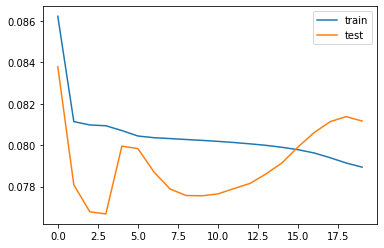

In [77]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [78]:
res = model.predict(X_te_reshaped)
res_inv = scaler.inverse_transform(res)

In [79]:
test_data['DL_PRED'] = res_inv
test_data['DL_PRED_SCALED'] = res
test_data['DEP_DELAY_SCALED'] = dep_delay_tescaled

In [80]:
np.sqrt(mean_squared_error(test_data.DEP_DELAY_SCALED,test_data.DL_PRED_SCALED))

0.11644865191305176

In [81]:
np.sqrt(mean_squared_error(test_data.DEP_DELAY,test_data.DL_PRED))

21.31010328597875

In [82]:
# keras_show = TimeSeries(test_data,x="FL_DATE",y=["DEP_DELAY","DL_PRED"],legend=True,plot_width=900, plot_height=350)
# show(keras_show)
sep_30m = test_data[test_data.FL_DATE >= pd.to_datetime("2019-11-29")]
# sep_30m = sep_30m.sort_values(by='FL_DATE',ascending=True)
sep_30m.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DAY_TYPE,IS_HOLIDAY,DEP_FROM_NY,T_1,T_2,T_3,T_4,T_5,DL_PRED,DL_PRED_SCALED,DEP_DELAY_SCALED
428718,2019-11-29 00:23:00,14107,83,12478,70,00:23:00,00:20:00,-3.0,04:59:00,06:05:00,66.0,0.0,0.0,276.0,345.0,224.0,1.0,2153.0,0,0,0,25.0,94.0,2.0,-9.0,-7.0,6.852923,0.223240,0.169399
428719,2019-11-29 00:30:00,12892,57,12478,70,00:30:00,00:21:00,-9.0,05:50:00,05:30:00,-20.0,0.0,0.0,320.0,309.0,284.0,1.0,2475.0,0,0,0,-3.0,25.0,94.0,2.0,-9.0,7.250635,0.225413,0.136612
428720,2019-11-29 02:50:00,12265,74,11697,36,02:50:00,02:59:00,9.0,05:49:00,05:47:00,-2.0,0.0,0.0,179.0,168.0,138.0,1.0,1176.0,0,0,1,-9.0,-3.0,25.0,94.0,2.0,3.142926,0.202967,0.234973
428721,2019-11-29 02:55:00,14025,85,11697,36,02:55:00,02:50:00,-5.0,06:22:00,06:21:00,-1.0,0.0,0.0,207.0,211.0,160.0,1.0,1334.0,0,0,1,9.0,-9.0,-3.0,25.0,94.0,2.930276,0.201805,0.158470
428722,2019-11-29 03:19:00,14254,86,12478,70,03:19:00,03:16:00,-3.0,07:18:00,07:28:00,10.0,0.0,0.0,239.0,252.0,234.0,1.0,1617.0,0,0,0,-5.0,9.0,-9.0,-3.0,25.0,1.270631,0.192736,0.169399


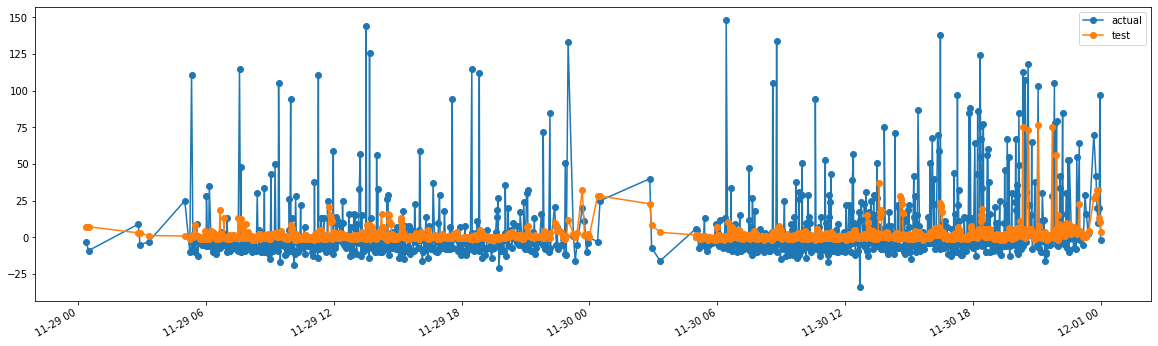

In [83]:
plt.figure(figsize=(20,6))
plt.plot_date(sep_30m['FL_DATE'], sep_30m['DEP_DELAY'], label='actual', linestyle ='solid')
plt.plot_date(sep_30m['FL_DATE'], sep_30m['DL_PRED'], label='test', linestyle ='solid')
plt.gcf().autofmt_xdate()
plt.legend()

In [84]:
p = figure(plot_width=950, plot_height=400, x_axis_type="datetime")

# add a line renderer
p.multi_line([sep_30m['FL_DATE'], sep_30m['FL_DATE']], [sep_30m['DL_PRED'], sep_30m['DEP_DELAY']], 
             color=["blue", "firebrick"], alpha=[0.8, 0.3], line_width=2, legend_label='pred')
# p.line(sep_30m['FL_DATE'], sep_30m['DL_PRED'], line_width=2, legend_label='pred')
# p.line(sep_30m['FL_DATE'], sep_30m['DEP_DELAY'], line_width=2, color='red', legend_label='actual')
p.legend.location = "top_left"
p.legend.click_policy="hide"

show(p)

In [85]:
sep_30m[['DEP_DELAY', 'DL_PRED']].tail(10)

,DEP_DELAY,DL_PRED
429907,16.0,0.199494
429908,2.0,3.051414
429909,4.0,4.029718
429910,70.0,26.743290
429911,42.0,29.015446
429912,20.0,32.139553
429913,10.0,32.236347
429914,20.0,13.203172
429915,97.0,10.518128
429916,-2.0,3.755203
